TODO

In [118]:
import os

import numpy as np
from matplotlib import pyplot as plt

from c3.c3objs import Quantity
from c3.experiment import Experiment
from c3.libraries.algorithms import lbfgs
from c3.libraries.envelopes import pwc
from c3.libraries.fidelities import unitary_infid_set
from c3.optimizers.optimalcontrol import OptimalControl
from c3.parametermap import ParameterMap
from c3.signal.pulse import Envelope
from playground.brute_force_opt_gate import get_2q_system
from playground.utils import calc_exp_fid


In [119]:
t_final = 45e-9
cx, model, generator, _ = get_2q_system('cx', __t_final=t_final)

parameter_map = ParameterMap(instructions=[cx], model=model, generator=generator)
cx_exp = Experiment(pmap=parameter_map)

Init amp is very important --- too low and it won't reach a high fidelity, too high and it'll give a pulse that wraps around and has high leakage.

In [120]:
def add_pwc_to_gate(init_amp: float, slices: int, gate, pmap):
    pwc_params1 = {
        "inphase": Quantity(value=np.random.randn(slices), unit="V"),
        "quadrature": Quantity(value=np.random.randn(slices), unit="V"),
        "amp": Quantity(value=init_amp, unit="V"),
        "xy_angle": Quantity(
            value=0.0, min_val=-0.5 * np.pi, max_val=2.5 * np.pi, unit="rad"
        ),
        "freq_offset": Quantity(value=0, min_val=-5 * 1e6, max_val=5 * 1e6, unit="Hz 2pi"),
    }
    pwc_params2 = {
        "inphase": Quantity(value=np.random.randn(slices), unit="V"),
        "quadrature": Quantity(value=np.random.randn(slices), unit="V"),
        "amp": Quantity(value=init_amp, unit="V"),
        "xy_angle": Quantity(
            value=0.0, min_val=-0.5 * np.pi, max_val=2.5 * np.pi, unit="rad"
        ),
        "freq_offset": Quantity(value=0, min_val=-5 * 1e6, max_val=5 * 1e6, unit="Hz 2pi"),
    }

    pwc_env1 = Envelope(
        name="pwc",
        desc="piecewise constant",
        params=pwc_params1,
        shape=pwc,
    )
    pwc_env2 = Envelope(
        name="pwc",
        desc="piecewise constant",
        params=pwc_params2,
        shape=pwc,
    )

    gate.add_component(pwc_env1, "d1")
    gate.add_component(pwc_env2, "d2")

    pmap.update_parameters()

In [121]:
awg_res = generator.devices['AWG'].resolution
slices = int(t_final * awg_res)
init_amp = 5e-2

add_pwc_to_gate(init_amp, slices, cx, parameter_map)

In [122]:
cx_name = cx.get_key()
cx_opt_map = [
    [
        (cx_name, "d1", "pwc", "amp"),
    ],
    [
        (cx_name, "d1", "pwc", "inphase"),
    ],
    [
        (cx_name, "d1", "pwc", "quadrature"),
    ],
    [
        (cx_name, "d2", "pwc", "amp"),
    ],
    [
        (cx_name, "d2", "pwc", "inphase"),
    ],
    [
        (cx_name, "d2", "pwc", "quadrature"),
    ]
]

parameter_map.set_opt_map(cx_opt_map)

It's important to keep a low

In [123]:
opt = OptimalControl(
    fid_func=unitary_infid_set,
    fid_subspace=["Q1", "Q2"],
    pmap=parameter_map,
    algorithm=lbfgs,
    options={"maxfun": 250},
    run_name="pwc_cx"
)

opt.set_exp(cx_exp)

In [124]:
opt.optimize_controls()

C3:STATUS:Saving as: C:\Users\YONATA~1\AppData\Local\Temp\tmpn01m_aub\c3logs\pwc_cx\2023_08_26_T_16_07_43\open_loop.c3log


  message: STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
  success: False
   status: 1
      fun: 0.017590543731302644
        x: [ 1.001e+00 -2.958e-02 ...  1.000e+00  9.982e-01]
      nit: 231
      jac: [ 1.937e-03 -6.161e-05 ...  1.516e-03 -2.058e-03]
     nfev: 251
     njev: 251
 hess_inv: <362x362 LbfgsInvHessProduct with dtype=float64>

Final fidelity:

In [125]:
cx_exp.compute_propagators()
calc_exp_fid(cx_exp)

0.9824094562686976

In [126]:
def plot_controls(pmap):
    for gate, instruction in pmap.instructions.items():
        fig, axs = plt.subplots(2)
        axs[0].set_title(gate.replace("_", "-"))
        legends = [[], []]
        for chan, channel in instruction.comps.items():
            for com, component in channel.items():
                if "t_final" in component.params:
                    ts = np.linspace(0, t_final, slices)
                    shape = component.get_shape_values(ts)
                    ax = axs[0]
                    ax.plot(ts[:len(shape)] / 1e-9, np.real(shape))
                    ax.plot(ts[:len(shape)] / 1e-9, np.imag(shape))
                    legends[0].append((chan, com.replace("_", "-"), "I"))
                    legends[0].append((chan, com.replace("_", "-"), "Q"))
                    ax = axs[1]
                    ax.plot(ts[:len(shape)] / 1e-9, np.abs(shape))
                    ax.plot(ts[:len(shape)] / 1e-9, np.angle(shape))
                    legends[1].append((chan, com.replace("_", "-"), "Abs"))
                    legends[1].append((chan, com.replace("_", "-"), "Phase"))
        ax = axs[0]
        ax.legend(legends[0])
        ax = axs[1]
        ax.set_xlabel("Time [ns]")
        ax.set_ylabel("Amplitude [normalized]")
        ax.legend(legends[1])


def plot_dynamics(exp, psi_init, seq, goal=-1):
    """
    Plotting code for time-resolved populations.

    Parameters
    ----------
    psi_init: tf.Tensor
        Initial state or density matrix.
    seq: list
        List of operations to apply to the initial state.
    goal: tf.float64
        Value of the goal function, if used.
    debug: boolean
        If true, return a matplotlib figure instead of saving.
    """
    model = exp.pmap.model
    exp.compute_propagators()
    dUs = exp.partial_propagators
    psi_t = psi_init.numpy()
    pop_t = exp.populations(psi_t, model.lindbladian)
    for gate in seq:
        for du in dUs[gate]:
            psi_t = np.matmul(du.numpy(), psi_t)
            pops = exp.populations(psi_t, model.lindbladian)
            pop_t = np.append(pop_t, pops, axis=1)

    fig, axs = plt.subplots(1, 1)
    ts = exp.ts
    dt = ts[1] - ts[0]
    ts = np.linspace(0.0, dt * pop_t.shape[1], pop_t.shape[1])
    axs.plot(ts / 1e-9, pop_t.T)
    axs.grid(linestyle="--")
    axs.tick_params(
        direction="in", left=True, right=True, top=True, bottom=True
    )
    axs.set_xlabel('Time [ns]')
    axs.set_ylabel('Population')
    plt.legend(model.state_labels)

Plot results:

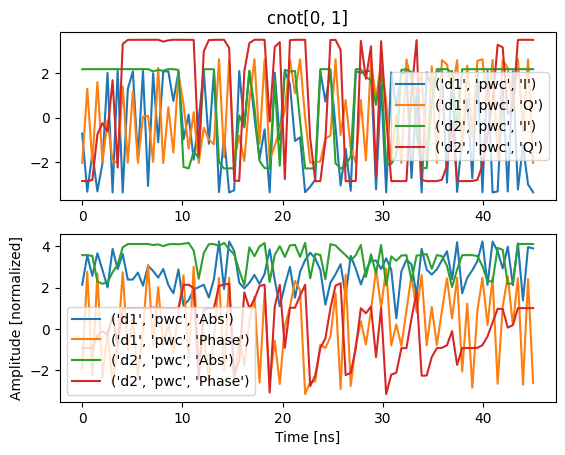

In [127]:
plot_controls(parameter_map)

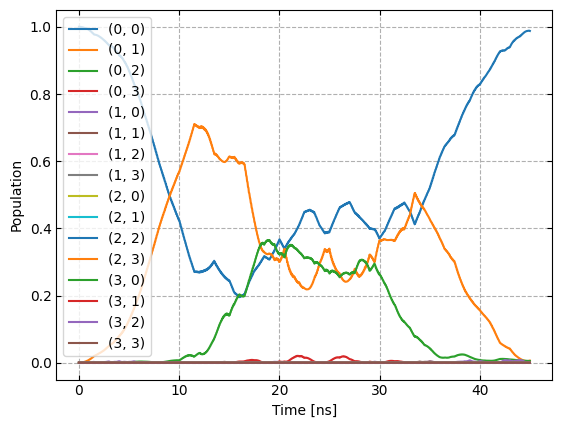

In [128]:
plot_dynamics(cx_exp, model.get_init_state(), [cx_name])

In [129]:
# cx_exp.write_config(os.path.join('plots_exps', 'cx_pwc.hjson'))

ZeroDivisionError: division by zero

As for the CZ experiment:

In [185]:
cz, model, generator, _ = get_2q_system('cy', __t_final=t_final)

cz_pmap = ParameterMap(instructions=[cz], model=model, generator=generator)
cz_exp = Experiment(pmap=cz_pmap)

In [186]:
add_pwc_to_gate(init_amp, slices, cz, cz_pmap)

In [187]:
cz_name = cz.get_key()
cz_opt_map = [
    [
        (cz_name, "d1", "pwc", "amp"),
    ],
    [
        (cz_name, "d1", "pwc", "inphase"),
    ],
    [
        (cz_name, "d1", "pwc", "quadrature"),
    ],
    [
        (cz_name, "d2", "pwc", "amp"),
    ],
    [
        (cz_name, "d2", "pwc", "inphase"),
    ],
    [
        (cz_name, "d2", "pwc", "quadrature"),
    ]
]

cz_pmap.set_opt_map(cz_opt_map)

TODO

In [188]:
cz_opt = OptimalControl(
    fid_func=unitary_infid_set,
    fid_subspace=["Q1", "Q2"],
    pmap=cz_pmap,
    algorithm=lbfgs,
    options={"maxfun": 500},
    run_name="pwc_cz"
)

cz_opt.set_exp(cz_exp)

In [189]:
cz_opt.optimize_controls()

C3:STATUS:Saving as: C:\Users\YONATA~1\AppData\Local\Temp\tmp78w95vdr\c3logs\pwc_cz\2023_08_26_T_17_25_38\open_loop.c3log


  message: STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
  success: False
   status: 1
      fun: 0.0025714717815948918
        x: [ 9.997e-01 -1.890e+00 ...  1.000e+00  1.003e+00]
      nit: 473
      jac: [-7.566e-04 -6.259e-05 ...  1.891e-04  1.433e-04]
     nfev: 501
     njev: 501
 hess_inv: <362x362 LbfgsInvHessProduct with dtype=float64>

Final fidelity:

In [190]:
cz_exp.compute_propagators()
calc_exp_fid(cz_exp)

0.9974285282184049

TODO

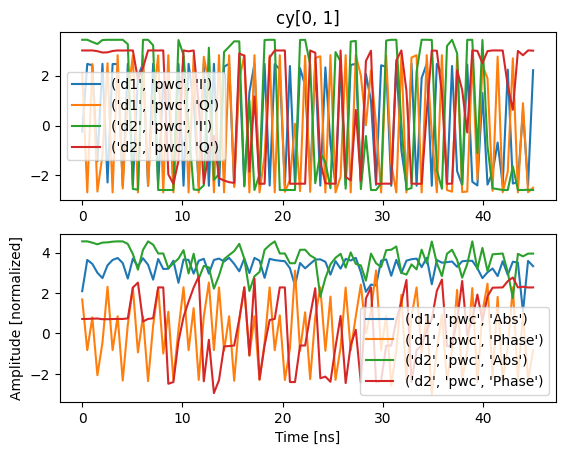

In [191]:
plot_controls(cz_pmap)

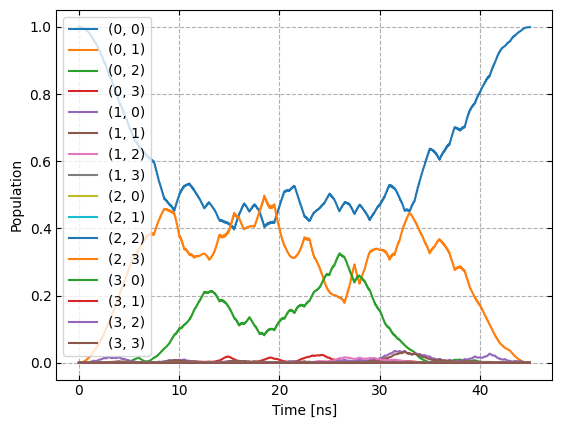

In [192]:
plot_dynamics(cz_exp, model.get_init_state(), [cz.get_key()])